In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
crawford_resnet50_path = kagglehub.dataset_download('crawford/resnet50')
imsparsh_deepweeds_path = kagglehub.dataset_download('imsparsh/deepweeds')
nithishgovind_resnet_weights_path = kagglehub.dataset_download('nithishgovind/resnet-weights')

print('Data source import complete.')


100%|██████████| 174M/174M [00:01<00:00, 138MB/s]

Extracting files...


100%|██████████| 470M/470M [00:03<00:00, 147MB/s]

Extracting files...


100%|██████████| 83.5M/83.5M [00:00<00:00, 165MB/s]

Extracting files...


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import os

print("DeepWeeds base path:", imsparsh_deepweeds_path)
for root, dirs, files in os.walk(imsparsh_deepweeds_path):
    print(root)
    for f in files:
        print("  ", f)
    break  # remove this break if you want full tree

DeepWeeds base path: /root/.cache/kagglehub/datasets/imsparsh/deepweeds/versions/2
/root/.cache/kagglehub/datasets/imsparsh/deepweeds/versions/2


In [3]:
import os
import random
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.utils as sku
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [4]:
def showImage(img):
    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.show()


In [8]:
basePath = imsparsh_deepweeds_path + '/'           # or just imsparsh_deepweeds_path
imgPath = os.path.join(basePath, 'images') + '/'
labelsBase = os.path.join(basePath, 'labels') + '/'
labelsPath = os.path.join(labelsBase, 'labels.csv')

print("labelsPath:", labelsPath)
labels_df = pd.read_csv(labelsPath)

labelsPath: /root/.cache/kagglehub/datasets/imsparsh/deepweeds/versions/2/labels/labels.csv


In [9]:
batch_size = 32
img_dim = 224
epoch=10
def getImgTensor(img_d):
    return (img_d, img_d, 3)
getImgTensor(img_dim)

(224, 224, 3)

In [10]:
# Shuffle the DataFrame
shuffled_df = labels_df.sample(frac=1, random_state=23)

# Split into train, val, and test
train_size = 0.75
val_size = 0.15
test_size = 0.1

# Calculate split indices
train_end = int(train_size * len(shuffled_df))
val_end = train_end + int(val_size * len(shuffled_df))

# Split the DataFrame
df_train = shuffled_df[:train_end]
df_val = shuffled_df[train_end:val_end]
df_test = shuffled_df[val_end:]

# Reset the index for each split
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Convert 'Label' column to string (if needed)
df_train['Label'] = df_train['Label'].astype('str')
df_val['Label'] = df_val['Label'].astype('str')
df_test['Label'] = df_test['Label'].astype('str')

# Print the sizes of the splits to verify
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Training set size: 13131
Validation set size: 2626
Test set size: 1752


/tmp/ipython-input-3939606653.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Label'] = df_train['Label'].astype('str')
/tmp/ipython-input-3939606653.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['Label'] = df_val['Label'].astype('str')
/tmp/ipython-input-3939606653.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [11]:
print(val_end)

15757


Label counts:
Label
8    9106
0    1125
6    1074
1    1064
4    1062
2    1031
3    1022
7    1016
5    1009
Name: count, dtype: int64


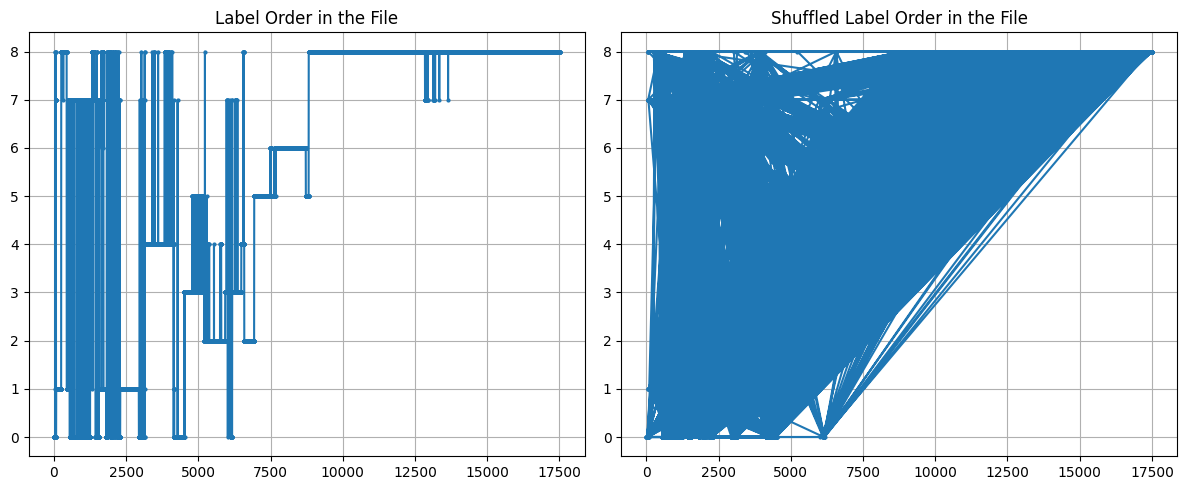

In [12]:
# Check the distribution of labels
label_counts = labels_df['Label'].value_counts()
print("Label counts:")
print(label_counts)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original label order
axes[0].plot(labels_df['Label'], marker='o', linestyle='-', markersize=2)
axes[0].set_title('Label Order in the File')
axes[0].grid(True)

# Shuffled label order
axes[1].plot(shuffled_df['Label'], marker='o', linestyle='-', markersize=2)
axes[1].set_title('Shuffled Label Order in the File')
axes[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()



In [13]:
df_train.head()

,Filename,Label,Species
0,20170811-114143-2.jpg,0,Chinee apple
1,20170217-102914-0.jpg,0,Chinee apple
2,20170811-114743-2.jpg,0,Chinee apple
3,20171109-194758-1.jpg,5,Rubber vine
4,20180112-070517-2.jpg,8,Negative


In [14]:

# Shear transformations (shear_range=0.2), which slant the image.
# Zoom operations (zoom_range=0.2), randomly zooming in/out.
# Horizontal flipping (horizontal_flip=True) to create mirror images.

# Image Data Generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)


In [15]:
# Train Generator
train_generator = train_datagen.flow_from_dataframe(
    directory=imgPath,
    dataframe=df_train,
    x_col='Filename',
    y_col='Label',
    batch_size=batch_size,
    color_mode="rgb",
    seed=23,
    shuffle=True,
    class_mode="categorical",
    target_size=(img_dim, img_dim)
)


Found 13131 validated image filenames belonging to 9 classes.


In [16]:
# Validation Generator
val_generator = val_datagen.flow_from_dataframe(
    directory=imgPath,
    dataframe=df_val,
    x_col='Filename',
    y_col='Label',
    batch_size=batch_size,
    color_mode="rgb",
    seed=23,
    shuffle=False,
    class_mode="categorical",
    target_size=getImgTensor(img_dim)[:2]
)

# Test Generator
test_generator = test_datagen.flow_from_dataframe(
    directory=imgPath,
    dataframe=df_test,
    x_col='Filename',
    y_col='Label',
    batch_size=batch_size,
    color_mode="rgb",
    seed=23,
    shuffle=False,
    class_mode="categorical",
    target_size=getImgTensor(img_dim)[:2]
)

Found 2626 validated image filenames belonging to 9 classes.
Found 1752 validated image filenames belonging to 9 classes.


In [17]:
# sku.class_weight.compute_class_weight with 'balanced' mode calculates weights inversely proportional to class frequencies

class_weights = sku.class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
train_class_weights = {i: x for i, x in enumerate(class_weights)}
print("class weights:", train_class_weights)

class weights: {0: np.float64(1.7536057692307692), 1: np.float64(1.7642079806529625), 2: np.float64(1.8850129198966408), 3: np.float64(1.8825806451612903), 4: np.float64(1.851522842639594), 5: np.float64(1.985034013605442), 6: np.float64(1.8421717171717171), 7: np.float64(1.8948051948051947), 8: np.float64(0.21336648142731793)}


Batch size: 32


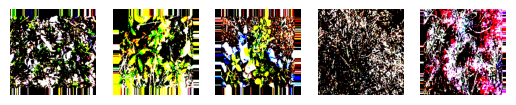

In [18]:

# images, labels = next(train_generator)
import matplotlib.pyplot as plt

# Get one batch
batch_images, batch_labels = next(train_generator)
print(f"Batch size: {batch_images.shape[0]}")

# Plot a few images from the batch
for i in range(min(5, batch_size)):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch_images[i])
    plt.axis('off')
plt.show()




In [19]:

total_samples = train_generator.n #orginal images
print(f"Total number of samples: {total_samples}")
class_counts = df_train['Label'].value_counts()
print("Number of samples per class:")
print(class_counts)



Total number of samples: 13131
Number of samples per class:
Label
8    6838
0     832
1     827
6     792
4     788
3     775
2     774
7     770
5     735
Name: count, dtype: int64


**Model**

In [20]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow Version:", tf.__version__)

# Check if using GPU
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.experimental.list_physical_devices('GPU'))


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Version: 2.19.0
Built with CUDA: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
# Add this BEFORE model creation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limit GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print("❌ GPU setup error:", e)


✅ GPU memory growth enabled


In [30]:
def squeeze_excite_block(input_tensor, ratio=16):
    # Get the number of channels (filters) in the input tensor
    channels = input_tensor.shape[-1]

    # Squeeze: Global Average Pooling across spatial dimensions
    squeeze = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

    # Excite: Two dense layers to learn channel-wise weights
    excitation = tf.keras.layers.Dense(channels // ratio, activation='relu')(squeeze)
    excitation = tf.keras.layers.Dense(channels, activation='sigmoid')(excitation)

    # Reshape excitation to match the input tensor's shape for multiplication
    excitation = tf.keras.layers.Reshape((1, 1, channels))(excitation)

    # Scale: Multiply the input tensor by the excitation weights
    scaled = tf.keras.layers.Multiply()([input_tensor, excitation])
    return scaled

In [31]:

from tensorflow import keras
from keras import applications
import os

# From kagglehub
# crawford_resnet50_path = kagglehub.dataset_download('crawford/resnet50')

resnet_weights_path = os.path.join(nithishgovind_resnet_weights_path, 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

print("resnet_weights_path:", resnet_weights_path)

base_model = applications.ResNet50(
    include_top=False,
    pooling= None,
    weights=resnet_weights_path
)

base_model.trainable = False


resnet_weights_path: /root/.cache/kagglehub/datasets/nithishgovind/resnet-weights/versions/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


Base model training freezing resnet

In [32]:
# 1) Freeze entire base model
base_model.trainable = False

inputs = tf.keras.Input(shape=getImgTensor(img_dim))  # e.g. (224,224,3)
x = base_model(inputs)                 # shape: (None, H, W, C)
x = squeeze_excite_block(x)           # shape: (None, H, W, C)
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # now (None, C)

x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(len(train_generator.class_indices),
                                activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_stage1 = model.fit(
    train_generator,
    epochs=epoch,  # e.g., 10–20
    class_weight=train_class_weights,
    validation_data=val_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 200s 445ms/step - accuracy: 0.4212 - loss: 1.5619 - val_accuracy: 0.6085 - val_loss: 1.2972
Epoch 2/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 164s 400ms/step - accuracy: 0.6352 - loss: 0.8598 - val_accuracy: 0.7113 - val_loss: 0.9137
Epoch 3/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 169s 411ms/step - accuracy: 0.6800 - loss: 0.7150 - val_accuracy: 0.7388 - val_loss: 0.7799
Epoch 4/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 165s 401ms/step - accuracy: 0.7047 - loss: 0.6336 - val_accuracy: 0.6801 - val_loss: 0.9828
Epoch 5/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 167s 405ms/step - accuracy: 0.7206 - loss: 0.5777 - val_accuracy: 0.7350 - val_loss: 0.8169
Epoch 6/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 164s 400ms/step - accuracy: 0.7399 - loss: 0.5169 - val_accuracy: 0.7422 - val_loss: 0.8160
Epoch 7/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 166s 403ms/step - accuracy: 0.7545 - loss: 0.4999 - val_accuracy: 0.7308 - val_loss: 0.8190
Epoch 8/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 165s 402ms/step - accuracy: 0.7688 -

In [41]:
more_epochs = 5

# early_stop = keras.callbacks.EarlyStopping(
#     monitor='val_loss',      # or 'val_accuracy'
#     patience=10,              # epochs with no improvement before stopping
#     mode='min',              # 'min' for loss, 'max' for accuracy
#     restore_best_weights=True,  # optional: roll back to best epoch
#     verbose=1
# )
epoch=50
history_fine = model.fit(
    train_generator,
    epochs=epoch + more_epochs,   # e.g., if epoch=10, this is 60
    initial_epoch=epoch,          # continue from previous epoch
    class_weight=train_class_weights,
    validation_data=val_generator,
    # callbacks=[early_stop]
)


Epoch 51/55
411/411 ━━━━━━━━━━━━━━━━━━━━ 166s 404ms/step - accuracy: 0.8898 - loss: 0.2090 - val_accuracy: 0.7567 - val_loss: 0.9866
Epoch 52/55
411/411 ━━━━━━━━━━━━━━━━━━━━ 166s 404ms/step - accuracy: 0.8898 - loss: 0.2021 - val_accuracy: 0.8172 - val_loss: 0.7603
Epoch 53/55
411/411 ━━━━━━━━━━━━━━━━━━━━ 167s 406ms/step - accuracy: 0.8968 - loss: 0.1989 - val_accuracy: 0.8244 - val_loss: 0.6689
Epoch 54/55
411/411 ━━━━━━━━━━━━━━━━━━━━ 164s 399ms/step - accuracy: 0.8932 - loss: 0.1908 - val_accuracy: 0.7898 - val_loss: 0.8021
Epoch 55/55
411/411 ━━━━━━━━━━━━━━━━━━━━ 170s 412ms/step - accuracy: 0.8916 - loss: 0.2014 - val_accuracy: 0.8046 - val_loss: 0.7790


In [42]:


# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')



55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8163 - loss: 0.6888

Test accuracy: 0.8145
Test loss: 0.6990


Unfreeze the base model - 20 layers

In [ ]:
# # 2) Unfreeze last N layers of base_model
# for layer in base_model.layers[-20:]:
#     layer.trainable = True

# # Optionally keep earlier layers frozen
# # for layer in base_model.layers[:-20]:
# #     layer.trainable = False

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # smaller LR
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# history_stage2 = model.fit(
#     train_generator,
#     epochs=epoch + extra_epochs,   # e.g., if epoch=20, extra_epochs=10 → total=30
#     initial_epoch=epoch,           # continue from previous
#     class_weight=train_class_weights,
#     validation_data=val_generator,
# )


In [ ]:


# # Evaluate the model on test data
# test_loss, test_acc = model.evaluate(test_generator)
# print(f'\nTest accuracy: {test_acc:.4f}')
# print(f'Test loss: {test_loss:.4f}')



In [43]:
import numpy as np
from sklearn.metrics import (classification_report, precision_recall_fscore_support,
                             confusion_matrix, average_precision_score)
from sklearn.preprocessing import label_binarize

# 1. Get predictions and true labels from test_generator
y_true = []
y_prob = []

for batch_imgs, batch_labels in test_generator:
    probs = model.predict(batch_imgs)
    y_prob.append(probs)
    y_true.append(np.argmax(batch_labels, axis=1))
    if len(y_true) * test_generator.batch_size >= test_generator.n:
        break

y_prob = np.concatenate(y_prob, axis=0)        # shape: (N, num_classes)
y_true = np.concatenate(y_true, axis=0)        # shape: (N,)
y_pred = np.argmax(y_prob, axis=1)

# 2. Precision / Recall / F1 (per-class + macro)
print(classification_report(y_true, y_pred))

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)
print("Macro Precision:", precision_macro)
print("Macro Recall:", recall_macro)
print("Macro F1:", f1_macro)

# 3. mAP@0.5 (classification analogue)
num_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=range(num_classes))

ap_per_class = []
for c in range(num_classes):
    ap = average_precision_score(y_true_onehot[:, c], y_prob[:, c])
    ap_per_class.append(ap)
mAP = np.mean(ap_per_class)
print("mAP (macro over classes):", mAP)

# 4. IoU per class and mean IoU (from confusion matrix)
cm = confusion_matrix(y_true, y_pred)
ious = []
for c in range(num_classes):
    tp = cm[c, c]
    fp = cm[:, c].sum() - tp
    fn = cm[c, :].sum() - tp
    denom = tp + fp + fn
    iou = tp / denom if denom > 0 else 0.0
    ious.append(iou)
mean_iou = np.mean(ious)
print("Mean IoU:", mean_iou)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

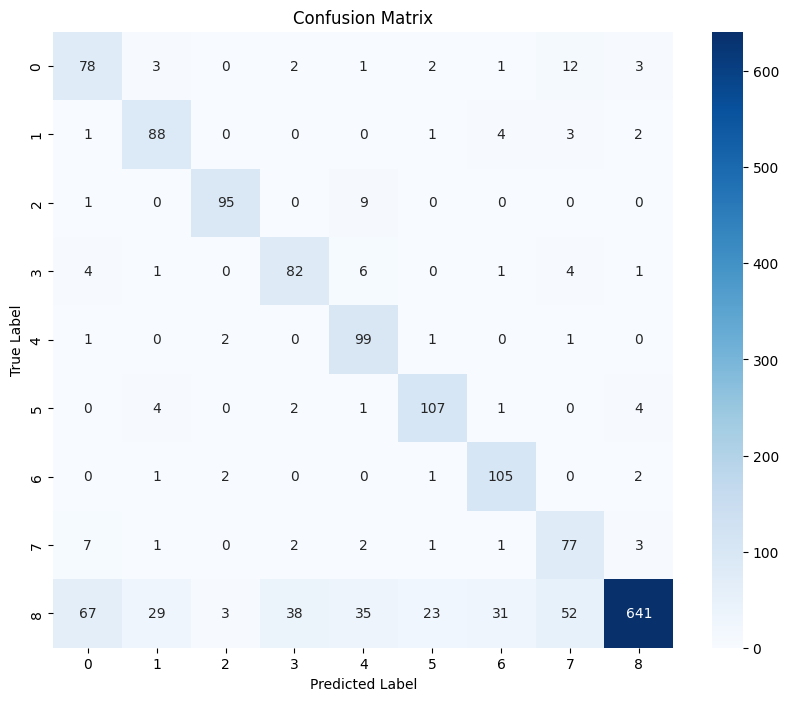

In [44]:
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

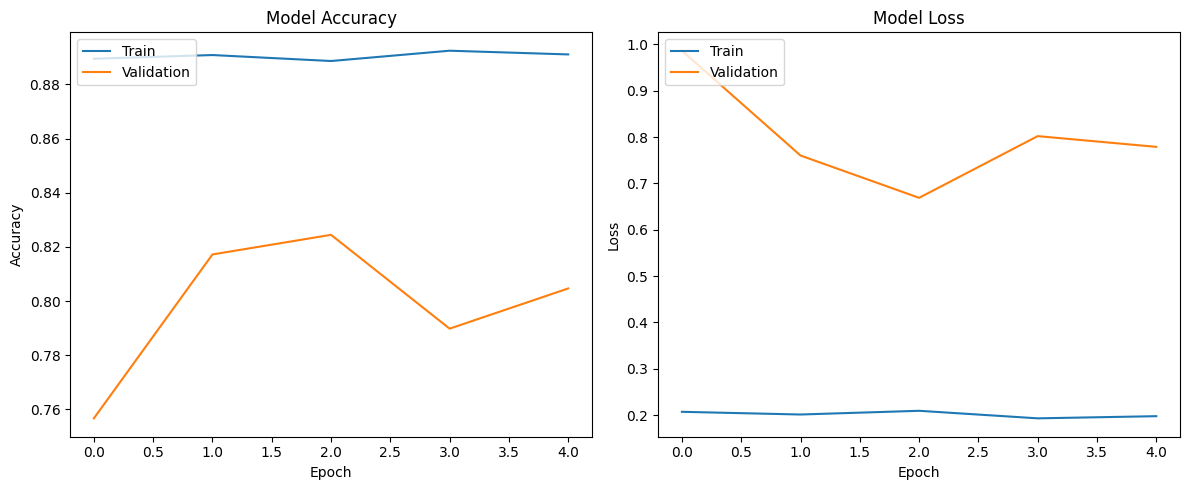

In [47]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

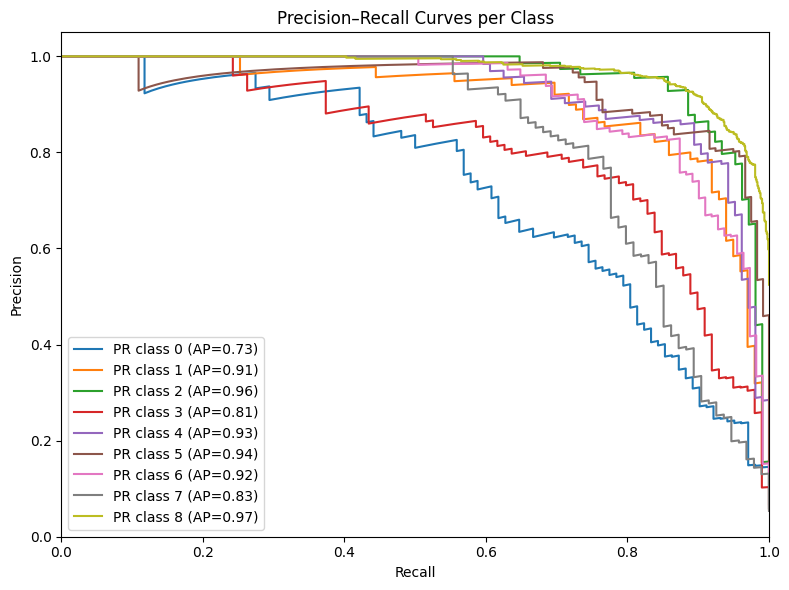

In [48]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())
n_classes = len(class_labels)

# 1) Get probabilities and true labels
y_true = []
y_prob = []

for batch_imgs, batch_labels in test_generator:
    probs = model.predict(batch_imgs)
    y_prob.append(probs)
    y_true.append(np.argmax(batch_labels, axis=1))
    if len(y_true) * test_generator.batch_size >= test_generator.n:
        break

y_prob = np.concatenate(y_prob, axis=0)          # (N, num_classes)
y_true = np.concatenate(y_true, axis=0)          # (N,)

# 2) Binarize true labels
y_test_bin = label_binarize(y_true, classes=np.arange(n_classes))  # (N, num_classes)

# 3) Compute PR + AP per class
precision = {}
recall = {}
average_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        y_test_bin[:, i], y_prob[:, i]      # use probs, not argmax
    )
    average_precision[i] = average_precision_score(
        y_test_bin[:, i], y_prob[:, i]
    )

# 4) Plot
colors = plt.cm.tab10.colors  # or any color list

plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors[:n_classes]):
    plt.plot(
        recall[i], precision[i], color=color,
        label=f'PR class {class_labels[i]} (AP={average_precision[i]:0.2f})'
    )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision–Recall Curves per Class')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [49]:
#inference
import time
import tensorflow as tf

# choose device: "/CPU:0" or "/GPU:0"
device = "/GPU:0"   # or "/CPU:0" for CPU numbers

# warm-up
for _ in range(5):
    _ = model.predict(next(test_generator)[0])

# measure
n_batches = 50    # adjust or use full test set
total_images = 0
start = time.time()

with tf.device(device):
    test_generator.reset()
    for i, (batch_imgs, _) in enumerate(test_generator):
        _ = model.predict(batch_imgs)
        total_images += batch_imgs.shape[0]
        if i + 1 >= n_batches or total_images >= test_generator.n:
            break

elapsed = time.time() - start
latency_ms = (elapsed / total_images) * 1000.0

print(f"Device: {device}, Images: {total_images}")
print(f"Average latency: {latency_ms:.2f} ms/image")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [50]:
# collect indices where model failed
mis_idx = np.where(y_true != y_pred)[0]
# Get class names from generator
class_names = list(test_generator.class_indices.keys())
# or, if you only have train_generator:
# class_names = list(train_generator.class_indices.keys())

# pick 8 diverse failures
sample_idx = mis_idx[:8]   # or np.random.choice(mis_idx, 8, replace=False)

# get file paths from your test generator / dataframe
# assuming you have a dataframe `df_test` aligned with generator order:
failed_files = [df_test.iloc[i]["Filename"] for i in sample_idx]
true_labels = [class_names[y_true[i]] for i in sample_idx]
pred_labels = [class_names[y_pred[i]] for i in sample_idx]


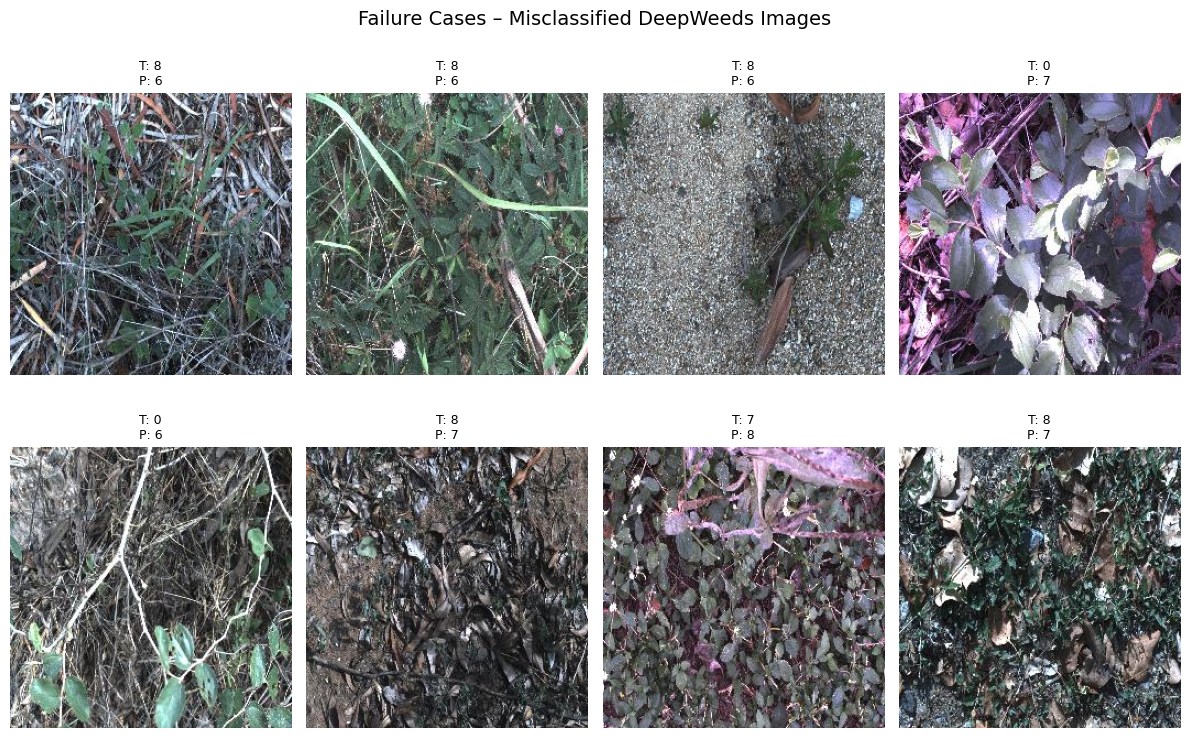

In [51]:
import matplotlib.pyplot as plt
import cv2
import os
test_image_root = imgPath
plt.figure(figsize=(12, 8))
for k, idx in enumerate(sample_idx):
    img_path = os.path.join(test_image_root, df_test.iloc[idx]["Filename"])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 4, k+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"T: {true_labels[k]}\nP: {pred_labels[k]}", fontsize=9)
plt.suptitle("Failure Cases – Misclassified DeepWeeds Images", fontsize=14)
plt.tight_layout()
plt.show()


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def apply_distortions_tensor_level(img):
    """
    img: single image from test_generator (float32, 0–1, RGB)
    Apply ultra-soft distortions directly in tensor space.
    """
    distortions = {}

    # original (no change)
    distortions["original"] = img.copy()

    # 1) Low-light: -2% brightness
    low_light = np.clip(img * 0.98, 0.0, 1.0)
    distortions["low_light"] = low_light

    # 2) Overexposure: +2% brightness
    overexp = np.clip(img * 1.02, 0.0, 1.0)
    distortions["overexposure"] = overexp

    # 3) Cool temp: +2% blue channel
    cool = img.copy()
    cool[..., 2] = np.clip(cool[..., 2] * 1.02, 0.0, 1.0)  # assuming channels: R,G,B
    distortions["cool_temp"] = cool

    # 4) Warm temp: +2% red channel
    warm = img.copy()
    warm[..., 0] = np.clip(warm[..., 0] * 1.02, 0.0, 1.0)
    distortions["warm_temp"] = warm

    # 5) Motion blur: light average of neighbors using small kernel
    # implement as simple 3x3 average filter
    from scipy.ndimage import uniform_filter
    motion_blur = uniform_filter(img, size=(3, 3, 1))
    distortions["motion_blur"] = motion_blur

    return distortions


In [53]:
test_batch = next(test_generator)[0][:20]  # shape: (20, H, W, 3), already 0–1 floats
results = []

for i, img in enumerate(test_batch):
    orig_pred = np.argmax(model.predict(img[None, ...], verbose=0))

    distortions = apply_distortions_tensor_level(img)

    for cond, dist_img in distortions.items():
        dist_pred = np.argmax(model.predict(dist_img[None, ...], verbose=0))
        results.append({
            "image_idx": i,
            "condition": cond,
            "true_label": orig_pred,
            "pred_label": dist_pred,
            "correct": orig_pred == dist_pred,
        })

df_results = pd.DataFrame(results)
acc = df_results.groupby("condition")["correct"].agg(["mean","count"])
acc["accuracy_%"] = (acc["mean"]*100).round(1)
print(acc[["accuracy_%","count"]])


              accuracy_%  count
condition                      
cool_temp           55.0     20
low_light           60.0     20
motion_blur         60.0     20
original           100.0     20
overexposure        60.0     20
warm_temp           35.0     20


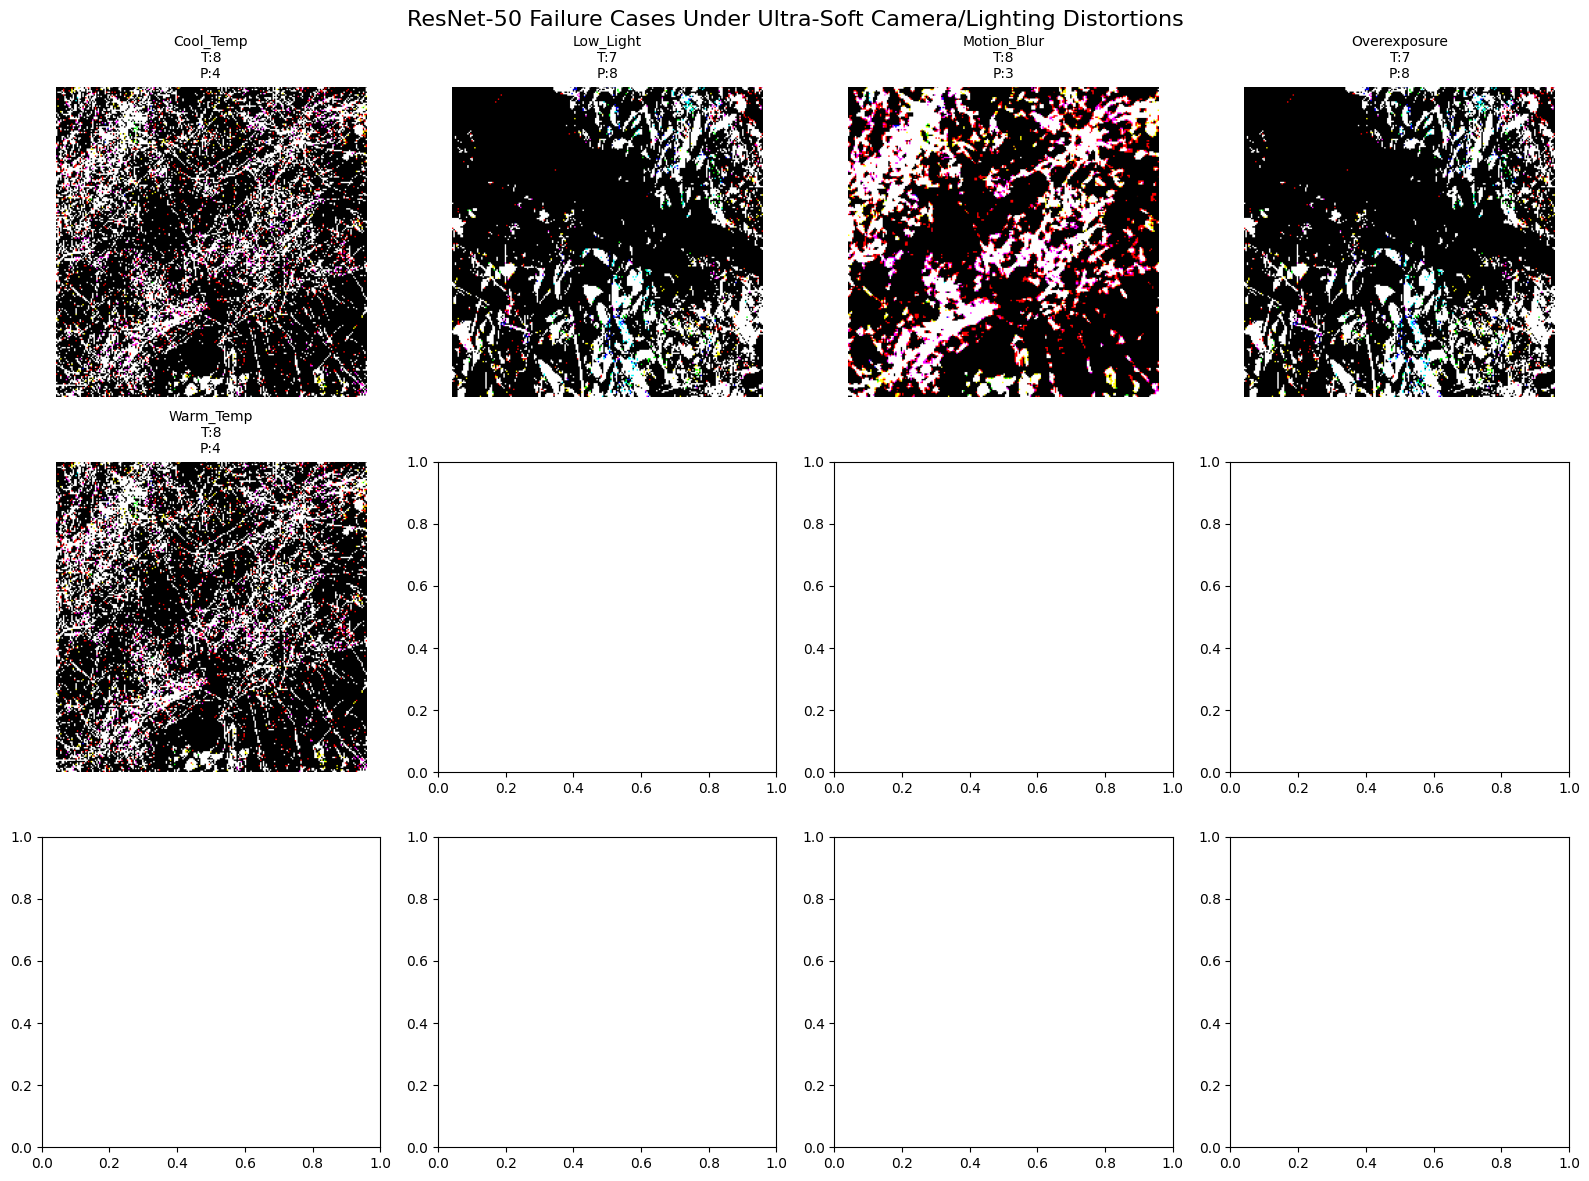

In [54]:
class_names = list(test_generator.class_indices.keys())

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for i, (cond, group) in enumerate(df_results[df_results["correct"] == False].groupby("condition")):
    if i >= 12:
        break
    sample = group.iloc[0]
    idx = sample["image_idx"]
    orig_img = test_batch[idx]
    dist_img = apply_distortions_tensor_level(orig_img)[sample["condition"]]

    axes[i].imshow(dist_img)
    axes[i].set_title(
        f"{sample['condition'].title()}\nT:{class_names[sample['true_label']]}\nP:{class_names[sample['pred_label']]}",
        fontsize=10,
    )
    axes[i].axis("off")

plt.suptitle("ResNet-50 Failure Cases Under Ultra-Soft Camera/Lighting Distortions", fontsize=16)
plt.tight_layout()
plt.savefig("figure4_camera_failures.png", dpi=150, bbox_inches="tight")
plt.show()
